<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H3/Assignment%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Influenza H1N1 2009 Pandemic in Sweden
During the fall of 2009 there was a large pandemic of the H1N1-virus, commonly known as the swine-flu. During this pandemic it is estimated that about 1.5 million people in Sweden were infected. As an attempt to stop the pandemic and reduce excess mortality the government issued a vaccination program beginning in week 40 of 2009. During the weeks that followed they vaccinated more than 60% of the Swedish population.

In this homework, you will simulate the pandemic with the goal of learning the network-structure characteristics and disease-dynamics parameters of the pandemic in Sweden 2009. This task will be divided into 4 parts where the focus of each part is to:
1. Get started and learn how to:

    a. Simulate a pandemic on a known graph

    b. Generate a random graph
2. Simulate the disease propagation on a random graph without vaccination
3. Simulate disease propagation on a random graph with vaccination
4. Estimate the network-structure characteristics and disease-dynamics parameters for the pandemic in Sweden during the fall of 2009

All numbers regarding the H1N1 pandemic in Sweden during the fall of 2009 have been taken from the a report by the Swedish Civil Contingencies Agency (Myndigheten for samhallsskydd och beredskap, MSB) and the Swedish Institute for Communicable Disease Control (Smittskyddsinstitutet, SMI).

## 1.1 Preliminary parts
As a warm-up exercise we will start off by doing two preliminary parts. The first one will involve simulating an epidemic on a given graph, while the second part will be to generate a random graph with preferential attachment.

### 1.1.1 Epidemic on a known graph
In this part you will simulate an epidemic on a symmetric k-regular undirected graph with node set $V=\left\{1,2,...,n\right\}$ where every node is directly connected to the $k=6$ nodes whose index is closest to their own modulo $n$. See Figure 1 for an example with 8 nodes. The graph that you will simulate the epidemic on will however contain $n=500$ nodes.
<figure>
    <img width="256" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H3/sources/F1.png"/>
    <figcaption>Figure 1: Symmetric $k$-regular graph.</figcaption>
</figure>
The disease propagation model that you will use to simulate the epidemic is a discrete-time simplified version of the SIR epidemic model. At any time $t=0,1,...$ nodes are in state $X_{i}\left(t\right) \in\left\{S,I,R \right\}$, where $S$ is susceptible, $I$ is infected and $R$ is recovered. Let $\beta \in \left[0,1\right]$ be the probability that the infection is spread from an infected individual to a susceptible one (given that they are connected by a link) during one time step. Assuming that a susceptible node $i$ has $m$ infected neighbors, this means that the probability that individual $i$ does not get infected by any of the neighbors during one time step is $\left(1-\beta \right)^{m}$. Thus, the probability that individual $i$ becomes infected by any of its neighbors is $1-\left(1-\beta \right)^{m}$. Furthermore, let $\rho \in \left[0,1\right]$ be the probability that an infected individual will recover during one time step. The epidemic is driven by the following transition probabilities
$$ \mathbb{P}\left(X_{i}\left(t+1 \right) =I \mid X_{i} \left( t\right) = S, \sum_{j\in V}W_{ij}\delta_{X_{j}\left(t\right)}^{I}=m \right) = 1-\left(1-\beta \right)^{m}$$
$$\mathbb{P}\left(X_{i}\left(t+1 \right) =R \mid X_{i} \left( t\right) = I \right)=\rho$$
where $\sum_{j\in V}W_{ij}\delta_{X_{j}\left(t\right)}^{I}$ is the number of infected neighbors for node $i$.

**Problem 1.1:** You should simulate an epidemic on a symmetric $k-$regular graph $G=\left(V, E\right)$ with $\left|V\right|=500$ nodes and $k=6$. See Figure 1 for an example with $n=8$ nodes and $k=6$. Let $\beta=0.25$ and $\rho=0.6$. With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at a random from the node set $V$, or make a different choice of initial configuration (In the latter case, please briefly discuss your motivation).

Do this $N=100$ times and plot the following:
* The average number of newly infected individuals each week. In other words, you should plot how many people *become* infected each week (On the average).
* The average total number of susceptible, infected, and recovered individuals at each week. In other words, you should plot how many individuals *in total are* susceptible/infected/recovered at each week (On the average).

**Hint:** Since we use a fairly large amount of nodes for this simulation it is good idea to use *sparse matrices* for this and the following problems.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
%matplotlib inline
options = {
    'node_size': 500,
    'width': 1, # width of the edges,
    'node_color': '#ffffff',
    'node_shape': 'o',
    'edge_color': 'black',
    'font_weight':'normal'
}
import progressbar
import time

In [ ]:
def custom_circulant_graph(n, k):
    #if condition returns False, AssertionError is raised:
    assert k % 2 == 0, "k must be even, i.e. k ∈ {2i | i ∈ N}"

    # Generate the circulant graph
    distances = [i for i in range(1, k // 2 + 1)]  # Set of distances (1, 2, ..., k/2)
    return nx.circulant_graph(n, distances)

In [ ]:
# Set parameters
n = 500
k = 6
beta = .25
rho = .6
week_to_simulate = 15
initial_infected_nodes = np.random.choice(range(n), 10)

# Create the graph
G = custom_circulant_graph(n, k)

# Set initial configuration of the node state
color_map = []
for i in range(n):
    if i in initial_infected_nodes:
        G.nodes[i]['state'] = 'I'
        color_map.append('red')
    else:
        G.nodes[i]['state'] = 'S'
        color_map.append('lightblue')

In [ ]:
# From G, get the infected neighbors of the node i
def get_infected_neighbors(G, i):
    infected_neighbors = [neighbor for neighbor in G.neighbors(i) if G.nodes[neighbor]['state'] == 'I']
    return infected_neighbors

In [ ]:
# Computes the probability that individual i becomes infected by any of its neighbors or
# the probability that an infected individual will recover during one time step.
def P(G, i, beta = None, rho = None):
        return 1- (1 - beta) ** len(get_infected_neighbors(G, i)) if beta is not None else rho

In [ ]:
def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    # We do not want to modify the original graph
    G = G.copy()

    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))
    nodes_infected = np.reshape([states.index(G.nodes[i]['state']) for i in G.nodes], (-1, 1))

    # New infected
    new_nodes_infected = [nodes_infected.sum()]

    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)

        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            if new_state == 'S':
                # 1 if i get infected, 0 otherwise
                i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected

In [ ]:
def Simulations(G, beta, rho, time_limit = 15, n_simulations = 100, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, time_limit))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

In [ ]:
# Extract and calculate the total number of S, I, and R nodes for each week
def calculate_average_states(simulations):
    time_limit = len(simulations[0][1])
    total_states = np.zeros((3, time_limit))  # For S, I, R
    for simulation in simulations: # Simulation has a tuple of matrix with 500 rows and 15 columns and a vector with the new infected
        states = simulation[0]  # Get the state history for each node
        for t in range(states.shape[1]): # states.shape[1] returns the number of weeks of the simulation
            # summing the number of S,I,R by each week
            total_states[0, t] += np.sum(states[:, t] == 0)  # Susceptible (S)
            total_states[1, t] += np.sum(states[:, t] == 1)  # Infected (I)
            total_states[2, t] += np.sum(states[:, t] == 2)  # Recovered (R)

    # Calculate the average across all simulations
    average_states = total_states / len(simulations) # we divide by the number of simulations length (simulations)
    return average_states

In [ ]:
def simplified_plot(data, title='', xlabel='', ylabel='', color='b', label=''):
    plt.plot(data, color=color, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [ ]:
nodes_infected, new_nodes_infected = EpidemicSimulation(G, beta, rho, week_to_simulate)

In [ ]:
S = Simulations(G, beta, rho, week_to_simulate)

100% (100 of 100) |######################| Elapsed Time: 0:00:11 Time:  0:00:11


In [ ]:
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)
average_new_nodes_infected

array([10.  , 13.02, 15.48, 14.8 , 13.15, 11.25,  9.6 ,  7.77,  6.87,
        6.11,  5.09,  4.25,  3.73,  3.06,  2.52,  2.4 ])

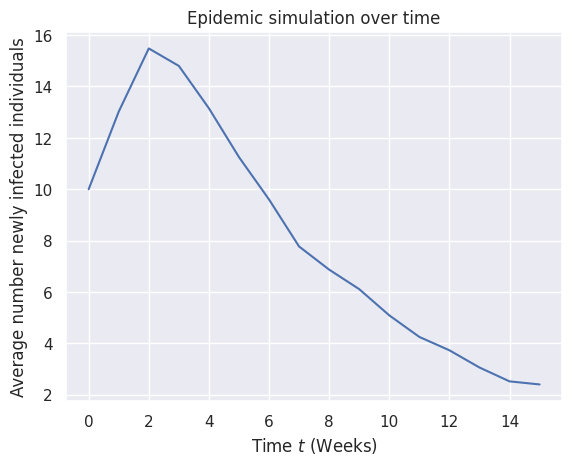

In [ ]:
simplified_plot(average_new_nodes_infected,
                title="Epidemic simulation over time",
                xlabel='Time $t$ (Weeks)',
                ylabel='Average number newly infected individuals'
                )
plt.show()

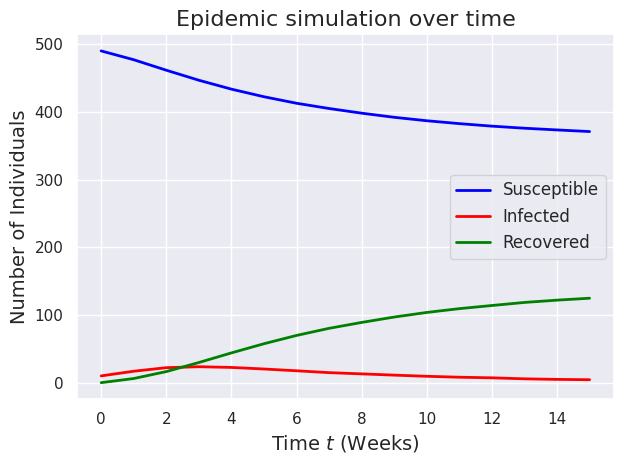

In [ ]:
# Calculate the average states for S, I, R
average_states = calculate_average_states(S)

# Plotting the results

plt.plot(average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic simulation over time", fontsize=16)
plt.xlabel("Time $t$ (Weeks)", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()